### BILSTM-CRF with Glove embedding

In [8]:
import json
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import gensim.downloader as api
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [2]:
# Load pre-trained word embeddings (GloVe)
glove_vectors = api.load("glove-wiki-gigaword-300")

In [3]:
startTag = "<START>"
stopTag = "<STOP>"

def log_sum_exp(vec):
    _, idx = torch.max(vec, 1)
    max_score = vec[0, idx.item()]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, word_embeddings):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.word_embeds = nn.Embedding.from_pretrained(word_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))
        self.transitions.data[tag_to_ix[startTag], :] = -10000
        self.transitions.data[:, tag_to_ix[stopTag]] = -10000
        self.hidden = (torch.randn(2, 1, self.hidden_dim // 2), torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        init_alphas[0][self.tag_to_ix[startTag]] = 0.
        forward_var = init_alphas
        for feat in feats:
            alphas_t = []
            for next_tag in range(self.tagset_size):
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                trans_score = self.transitions[next_tag].view(1, -1)
                next_tag_var = forward_var + trans_score + emit_score
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[stopTag]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def get_features(self, sentence):
        self.hidden = (torch.randn(2, 1, self.hidden_dim // 2), torch.randn(2, 1, self.hidden_dim // 2))
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def sentence_score(self, feats, tags):
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[startTag]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[stopTag], tags[-1]]
        return score

    def neg_log_likelihood(self, sentence, tags):
        feats = self.get_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self.sentence_score(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  
        feats = self.get_features(sentence)
        backpointers = []
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[startTag]] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []
            viterbivars_t = []
            for next_tag in range(self.tagset_size):
                next_tag_var = forward_var + self.transitions[next_tag]
                _, idx = torch.max(next_tag_var, 1)
                best_tag_id = idx.item()
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)
        
        terminal_var = forward_var + self.transitions[self.tag_to_ix[stopTag]]
        _, idx = torch.max(terminal_var, 1)
        best_tag_id = idx.item()
        path_score = terminal_var[0][best_tag_id]
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
            
        start = best_path.pop()
        assert start == self.tag_to_ix[startTag]
        best_path.reverse()
        return path_score, best_path

In [9]:
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    training_data = []
    for key, value in data.items():
        text = value["text"]
        labels = value["labels"]
        training_data.append((text, " ".join(labels)))

    data = []
    for i in training_data:
        data.append((i[0].split(), i[1].split()))
    return data

test_data = load_data('ATE_test.json')

def prepare_sequence(seq, to_idx):
    vocab_size = len(to_idx)
    idxs = []
    for w in seq:
        if w in to_idx:
            idxs.append(to_idx[w])
        else:
            idxs.append(random.randint(0, vocab_size - 1))
    return torch.tensor(idxs, dtype=torch.long)

# Define model parameters
embedding_dim = glove_vectors.vectors.shape[1]
vocab_size = len(glove_vectors.key_to_index) + 1  # Add 1 for the padding token
hidden_dim = 8
tagset_size = 3

In [10]:
word_to_idx_glove = {word: idx + 1 for idx, word in enumerate(glove_vectors.index_to_key)}
label_to_idx = {'B':0, 'I':1, 'O':2, '<START>':3, '<STOP>':4} 
HIDDEN_DIM = 8

glove_state_dict = torch.load('t2_model4_GloVe.pt')
glove_model = BiLSTM_CRF(len(word_to_idx_glove), label_to_idx, glove_vectors.vector_size, HIDDEN_DIM, torch.FloatTensor(glove_vectors.vectors))
glove_model.load_state_dict(glove_state_dict)
glove_model.eval()

BiLSTM_CRF(
  (word_embeds): Embedding(400000, 300)
  (lstm): LSTM(300, 4, bidirectional=True)
  (hidden2tag): Linear(in_features=8, out_features=5, bias=True)
)

In [12]:
# Calculate label-wise F1 scores
label_to_idx = {'B': 0, 'I': 1, 'O': 2}  # Assuming this is the label-to-index mapping
all_predictions = []
all_labels = []
with torch.no_grad():
    for sentence, labels in test_data:
        sentence_in = prepare_sequence(sentence, word_to_idx_glove)
        predictions = glove_model(sentence_in)
        predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(p)] for p in predictions[1]]
        all_predictions.extend(predicted_labels)
        all_labels.extend(labels)

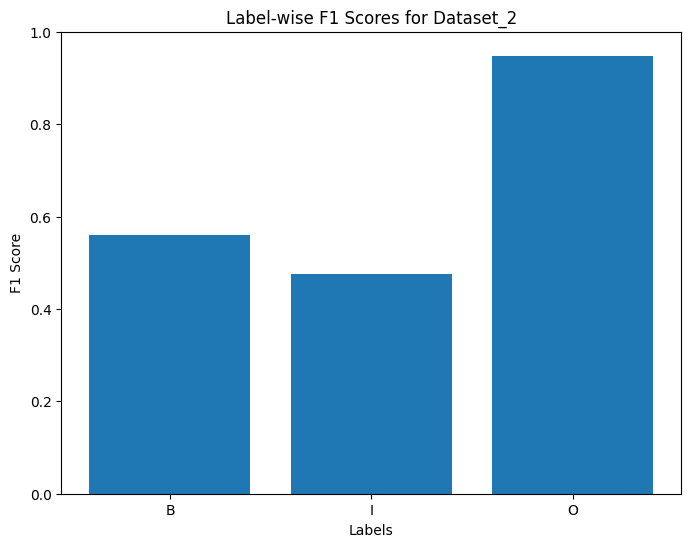

In [13]:
label_f1_scores = {}
for label in label_to_idx.keys():
    label_preds = [1 if pred == label else 0 for pred in all_predictions]
    label_labels = [1 if lbl == label else 0 for lbl in all_labels]
    label_f1_scores[label] = f1_score(label_labels, label_preds)

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(label_f1_scores.keys(), label_f1_scores.values())
plt.xlabel('Labels')
plt.ylabel('F1 Score')
plt.title('Label-wise F1 Scores for Dataset_2')
plt.ylim(0, 1)
plt.show()

In [14]:
label_f1_scores

{'B': 0.5593008739076155, 'I': 0.47665847665847666, 'O': 0.9472301291876505}